#Nous choisissons le Sujet B pour créer un backtester pour Stratégies d’Investissement

##Partie 1 
**Au début, nous avons introduit les bibliothèques dont nous avons besoin pour mieux traiter et appeler les données, mieux utiliser les fonctions et dessiner des images. Nos données financières proviennent de Yahoo Finance. ("math" fournit un ensemble de fonctions mathématiques et de constantes pour effectuer des opérations mathématiques courantes. Telles que des fonctions trigonométriques, des fonctions exponentielles, des fonctions logarithmiques, des constantes, etc. "from typing import Dict" Cette ligne de code est utilisée pour importer le type Dict . Ce type est utilisé pour représenter la structure clé d'un dictionnaire).**

**Nous avons créé une classe appelée Backtester pour effectuer des backtests de stratégie financière. init est le constructeur (méthode d'initialisation) de la classe Backtester, qui accepte des paramètres entre parenthèses, tels que : une liste ou un tableau contenant des noms d'actifs, un dictionnaire contenant des données de cours de clôture d'actifs, un dictionnaire contenant des données de signaux de trading, etc. Dans la fonction, attribuez les paramètres transmis aux variables d'instance.**

**'load_data' est de charger les données d'actifs et de les stocker dans l'exemple de variable "self.data". Nous initialisons d’abord un dictionnaire vide pour stocker les données d’actifs chargées. Nous construisons ensuite le chemin d'accès au fichier de données d'actif et lisons les données, en nous assurant que le fichier et le chemin existent.**

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf
import os
from typing import Dict


class Backtester:

    def __init__(self, asset_names, asset_closes, signals, weights, risk_free_rate, market_returns,data_folder='Data'):
        self.data_folder = data_folder
        self.asset_names = asset_names
        self.asset_closes = asset_closes
        self.signals = signals
        self.weights = weights
        self.risk_free_rate = risk_free_rate
        self.market_returns = market_returns
        self.max_drawdown = 0.0
        self.max_seen_peak = 0
        self.load_data()

    def load_data(self):
        self.data = {}
        for asset_name in self.asset_names:
            file_path = os.path.join(self.data_folder, f'{asset_name}.csv')
            if os.path.exists(file_path):
               self.data[asset_name] = pd.read_csv(file_path, index_col=0, parse_dates=True)
            else:
                print(f'Data file for {asset_name} not found.')

**La fonction 'Strategy' implémente une stratégie de Simple Moving Average. Elle prend en entrée un dictionnaire nommé 'dfs' contenant les données boursières, où les clés représentent les noms des actions et les valeurs correspondent aux DataFrames associés. Pour chaque action' elle exécute les étapes suivantes : elle calcule la volatilité et l'amplitude des prix, détermine la taille de la fenêtre des moyennes mobiles à court et à long terme en fonction de ces paramètres, initialise la valeur de la colonne de signaux à 0, calcule les moyennes mobiles à court et à long terme dans le DataFrame d'origine et génère des signaux d’achat/vente en fonction de leur intersection (1 pour achat, -1 pour vente). La logique sous-jacente à la génération des signaux est que lorsque la moyenne mobile à court terme croise la moyenne mobile à long terme à la hausse, un signal d’achat est généré, indiquant une probable augmentation des prix, tandis qu'un croisement à la baisse génère un signal de vente, indiquant une possible baisse des prix. De plus, pour éviter tout biais de données futur, le signal est avancé d'un jour. La fonction 'run_strategy' est utilisée pour exécuter la stratégie spécifiée et afficher les signaux pour chaque action.**

**Pour chaque actif, nous calculons le rendement quotidien et le rendement annualisé en fonction du cours de clôture quotidien et des signaux de trading. Ensuite, nous calculons la volatilité de l'actif. La fonction 'calculate_asset_volatility' prend en entrée le rendement quotidien d'un actif et calcule sa volatilité en utilisant la formule de l'écart type, puis en multipliant par la racine carrée de 252 pour convertir la volatilité quotidienne en volatilité annuelle. Un autre point important concerne le tirage maximal pour un seul actif. Le code s'initialise puis calcule le max drawdown de l'actif. Il parcourt les prix de clôture de chaque actif et calcule le pourcentage de max drawdown.**

**En ce qui concerne un portefeuille, nous analysons ses données financières : rendement quotidien, rendement annualisé, volatilité, ratio de Sharpe et bêta. Ces mesures sont calculées à partir des données de rendement quotidien et du rendement du marché pour un actif, et le bêta du portefeuille peut être calculé séparément en fonction des périodes de hausse et de baisse du marché.**

In [4]:
    # Double Moving Average Strategy
    def strategy(self, dfs: Dict[str, pd.DataFrame]):
        signals = {}
        for asset_name, df in dfs.items():
             # Calculate customized moving average windows based on stock-specific characteristics
            volatility = df['Close'].std() 
            price_range = df['Close'].max() - df['Close'].min() 
            short_window = int(volatility * 0.5)  
            long_window = int(price_range * 0.1)  
            # Initialize signals DataFrame
            signals[asset_name] = pd.DataFrame(index=df.index)
            signals[asset_name]['Signal'] = 0.0
            # Calculate short-term and long-term moving averages            
            df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
            df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
             # Generate signals
            df=df.dropna()
            df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, -1)
            signals[asset_name]['Signal'] = df['Signal'].shift(1)
        return signals

    def run_strategy(self, strategy_name: str, data: Dict[str, pd.DataFrame]):
        signals = self.strategy(data)
        all_signals = pd.concat(signals.values(), axis=1, keys=signals.keys())
        print("Signals for all assets:")
        print(all_signals)
            
    def calculate_asset_daily_returns(self):
        asset_daily_returns = pd.DataFrame()
        for asset_name, asset_data in self.asset_closes.items():
            if asset_name in self.signals:
               asset_daily_returns[asset_name] = self.data[asset_name]['Close'].pct_change() * self.signals[asset_name].shift(1).iloc[:, 0]
            else:
               print(f'No signals found for {asset_name}.')
        return asset_daily_returns
    
    def calculate_asset_annualized_returns(self):
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = {}
        for asset_name, asset_daily_return in asset_daily_returns.items():
            total_days = len(asset_daily_return)
            if total_days > 0:
                asset_annualized_return = ((asset_daily_return + 1).prod()) ** (252 / total_days) - 1 
                asset_annualized_returns[asset_name] = asset_annualized_return
            else:
                print(f'No daily returns found for {asset_name}.')
        return asset_annualized_returns

    def calculate_asset_volatility(self, asset_daily_returns):
        asset_volatility = asset_daily_returns.std() * math.sqrt(252)
        return asset_volatility
          
    def start(self):
        self.max_drawdown = 0.0
        self.max_seen_peak = 0

    def calculate_max_drawdown(self, asset_name):
        price_series = self.data[asset_name]['Close']
        peak = price_series.iloc[0]
        max_drawdown = 0
        for price in price_series:
            if price > peak:
                peak = price
            drawdown = (peak - price) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
        self.max_drawdown = max_drawdown * 100
   
    def calculate_portfolio_daily_returns(self, asset_daily_returns):
        pf_daily_returns = (asset_daily_returns * repeated_weights).sum(axis=1)
        return pf_daily_returns
    
    def calculate_portfolio_annualized_returns(self, asset_daily_returns):
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        total_days = len(pf_daily_returns)
        if total_days > 0:
            pf_annualized_return = ((pf_daily_returns + 1).prod()) ** (252 / total_days) - 1 
            return pf_annualized_return
        else:
            print(f'No daily returns found for portfolio.')
            return None

    def calculate_portfolio_volatility(self, pf_daily_returns):
        pf_volatility = pf_daily_returns.std() * math.sqrt(252)
        return pf_volatility

    def calculate_annualized_sharpe_ratio(self, pf_daily_returns):
        avg_return = pf_daily_returns.mean()
        std_dev = pf_daily_returns.std()
        annualized_sharpe_ratio = (avg_return - self.risk_free_rate) / std_dev * math.sqrt(252)
        return annualized_sharpe_ratio

    def calculate_beta(self, pf_daily_returns):
        pf_daily_returns_aligned, market_returns_aligned = pf_daily_returns.align(self.market_returns, join='inner')
        cov_matrix = np.cov(pf_daily_returns_aligned, market_returns_aligned)
        portfolio_covariance = cov_matrix[0, 1]
        market_variance = np.var(market_returns_aligned)
        beta = portfolio_covariance / market_variance
        return beta

    def calculate_beta_up_down(self, daily_returns):
        daily_returns_aligned, market_returns_aligned = daily_returns.align(self.market_returns, join='inner')
        market_up_returns = market_returns_aligned[market_returns_aligned > 0]
        market_down_returns = market_returns_aligned[market_returns_aligned < 0]
        pf_up_returns = daily_returns_aligned[self.market_returns > 0]
        pf_down_returns = daily_returns_aligned[self.market_returns < 0]
        beta_up = self.calculate_beta(pf_up_returns)
        beta_down = self.calculate_beta(pf_down_returns)
        return beta_up, beta_down 

**'summary' est de calculer et de renvoyer des informations récapitulatives de la stratégie. Les résultats peuvent afficher le rendement quotidien, le rendement annualisé, la volatilité, le ratio de Sharpe, le coefficient bêta, le prélèvement maximum, etc. pour chaque actif et portefeuille. En bref, le résumé du dictionnaire contient des informations récapitulatives sur la stratégie, notamment les valeurs de divers indicateurs et des résumés de signaux.**

**'plot' est utilisé pour tracer les rendements des actifs et des portefeuilles, ainsi que la volatilité des portefeuilles. Introduisez ensuite les données, définissez le titre, la taille du graphique et la couleur de la courbe, puis ajoutez une légende.**

In [ ]:
    def summary(self):
        for asset_name, asset_close in asset_closes.items():
            backtester.calculate_max_drawdown(asset_name)  # Pass asset_name instead of asset_close
            print(f"max_drawdown ({asset_name}): {backtester.max_drawdown}")
        
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = self.calculate_asset_annualized_returns()
        asset_volatility = self.calculate_asset_volatility(asset_daily_returns)
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        pf_annualized_returns = self.calculate_portfolio_annualized_returns(asset_daily_returns)
        pf_volatility = self.calculate_portfolio_volatility(pf_daily_returns)
        annualized_sharpe_ratio = self.calculate_annualized_sharpe_ratio(pf_daily_returns)
        beta = self.calculate_beta(pf_daily_returns)
        beta_up, beta_down = self.calculate_beta_up_down(pf_daily_returns)
        max_drawdown = self.max_drawdown

        signals_summary = {asset_name: self.signals[asset_name] for asset_name in self.asset_names}

        summary = {
            "asset_daily_returns": asset_daily_returns,
            "asset_annualized_returns": asset_annualized_returns,
            "asset_volatility": asset_volatility,
            "pf_daily_returns": pf_daily_returns,
            "pf_annualized_returns": pf_annualized_returns,
            "pf_volatility": pf_volatility,
            "annualized_sharpe_ratio": annualized_sharpe_ratio,
            "beta": beta,
            "beta_up": beta_up,
            "beta_down": beta_down,
        }
        return summary

    def plot(self):
        # Plot asset returns
        plt.figure(figsize=(12, 6))
        for asset_name, asset_data in self.asset_closes.items():
            asset_returns = self.data[asset_name]['Close'].pct_change()
            plt.plot(asset_returns.index, asset_returns, label=asset_name)
        # Plot portfolio returns
        pf_daily_returns = self.calculate_portfolio_daily_returns(self.calculate_asset_daily_returns())
        plt.plot(pf_daily_returns.index, pf_daily_returns, label='Portfolio Returns', color='red')
        plt.title('Asset and Portfolio Daily Returns')
        plt.xlabel('Date')
        plt.ylabel('Daily Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        # Plot portfolio volatility
        plt.figure(figsize=(12, 6))
        plt.plot(pf_daily_returns.index, pf_daily_returns.rolling(window=20).std() * math.sqrt(252),
                 label='Portfolio Volatility', color='green')
        plt.title('Portfolio Volatility (Rolling 20-Day Window)')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#Partie 2 

##Utiliser de backtester dans la stratégie

**Utilisez la classe Backtester pour effectuer des tests Backtester de stratégies de trading basées sur des données historiques.**

**Utilisez 'AAPL', 'AMZN', 'GOOGL'. Téléchargez les données boursières pour une période de données personnalisée à partir de Yahoo Finance et enregistrez-les dans un fichier CSV. Créez un exemple de Backtester, exécutez une stratégie (basée sur un simple croisement de moyenne mobile) et obtenez des données de signal,qui sont utilisées pour calculer les rendements, etc. (décider d'acheter ou de vendre). Calculez et imprimez des informations de backtest telles que les rendements, les rendements annualisés, la volatilité, le ratio de Sharpe, le bêta, etc. Tracez enfin les courbes de rendement des actifs et du portefeuille ainsi que la courbe de volatilité du portefeuille.**

Signals for all assets:
             AAPL   AMZN  GOOGL
           Signal Signal Signal
Date                           
2022-01-03    NaN    NaN    NaN
2022-01-04   -1.0   -1.0   -1.0
2022-01-05   -1.0   -1.0   -1.0
2022-01-06   -1.0   -1.0   -1.0
2022-01-07   -1.0   -1.0   -1.0
...           ...    ...    ...
2023-12-22   -1.0   -1.0   -1.0
2023-12-26    1.0   -1.0   -1.0
2023-12-27    1.0   -1.0   -1.0
2023-12-28    1.0   -1.0   -1.0
2023-12-29    1.0   -1.0   -1.0

[501 rows x 3 columns]
max_drawdown (AAPL): 31.311466174254026
max_drawdown (AMZN): 51.98483491885341
max_drawdown (GOOGL): 43.62837817217853
Summary:
{'asset_daily_returns':                 AAPL      AMZN     GOOGL
Date                                    
2022-01-03       NaN       NaN       NaN
2022-01-04       NaN       NaN       NaN
2022-01-05  0.026600  0.018893  0.045876
2022-01-06  0.016693  0.006711  0.000200
2022-01-07 -0.000988  0.004288  0.005303
...              ...       ...       ...
2023-12-22  0.005547  0.

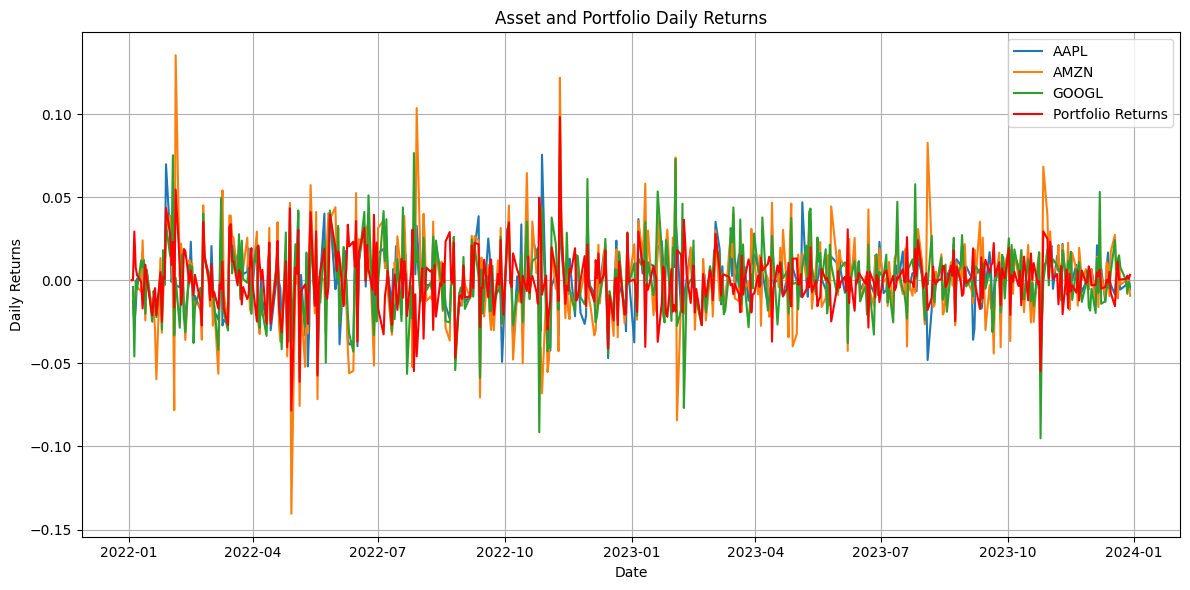

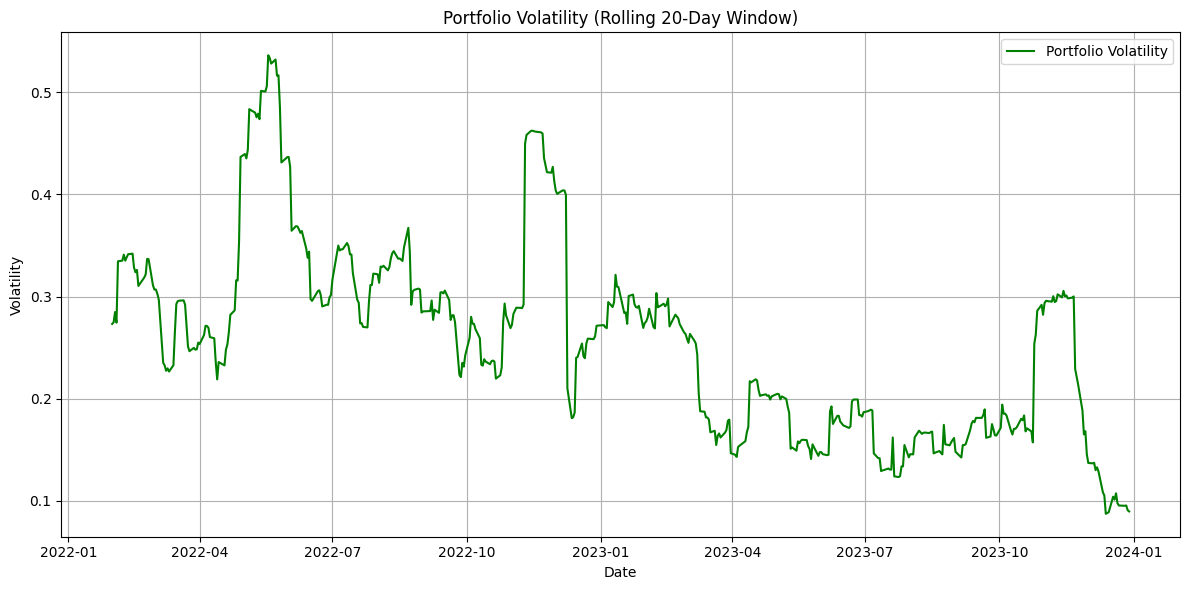

In [5]:
# Exampl usage
stock_symbols = ['AAPL', 'AMZN', 'GOOGL']
asset_names = stock_symbols
data_folder = 'Data'
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if not os.path.exists(file_path):
        print(f'Downloading {symbol} data...')
        data = yf.download(symbol, start='2022-01-01', end='2023-12-31')
        data.to_csv(file_path)
        print(f'Data saved to {file_path}')

# Load your data into a dictionary
data = {}
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if os.path.exists(file_path):
        data[symbol] = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f'Data file for {symbol} not found.')

# Create data
dates = pd.date_range(start='2022-01-01', end='2023-12-31')
num_assets = len(stock_symbols)
num_days = len(dates)
asset_closes = pd.DataFrame(np.random.randn(num_days, num_assets), index=dates, columns=stock_symbols)

# Obtenir la quantité de date
dates_count = len(next(iter(data.values())).index)
n = dates_count
# weights
weights = np.array([0.3, 0.4, 0.3])
repeated_weights = np.tile(weights, (n, 1))

# Assume risk-free rate as 0.02
risk_free_rate = 0.02

# Assume market returns data
market_returns = pd.Series(np.random.randn(num_days), index=dates)

# Create a Backtester instance
backtester = Backtester(asset_names, asset_closes,None , weights, risk_free_rate, market_returns, data_folder='Data')
signals = backtester.strategy(data)   
backtester.signals = signals

# Run the strategy 
backtester.run_strategy('strategy', data)

# Calculate and print summary information
summary = backtester.summary()
print("Summary:")
print(summary)

# Plot asset and portfolio daily returns as well as portfolio volatility
backtester.plot()

#Analyser les résultats

##Analyse d'un actif

**'Asset Annualized Returns': AAPL:-19.51% ; AMZN:-17.26% ; GOOGL:46.38%**

**AAPL et AMZN ont tous deux des rendements annualisés négatifs, ce qui indique qu'investir dans ces deux actions entraînera des pertes au cours de la période de backtest.GOOGL s'est bien comporté et a obtenu un taux de rendement annualisé positif, ce qui indique qu'il a généré des bénéfices pour les investisseurs au cours de la période de backtest.**

**'Asset Volatility': AAPL:29.07% ; AMZN:42.60% ;GOOGL:34.80%**

**AMZN présente la volatilité la plus élevée, ce qui indique qu'il présente le plus de fluctuations de prix et le risque le plus élevé.AAPL et GOOGL sont des investissements moins volatils, mais toujours plus risqués.**

**'Asset Daily Returns' et 'Portfolio Daily Returns':Les données de rendement quotidien montrent que GOOGL affiche des rendements positifs plus élevés certains jours, ce qui est cohérent avec son rendement annualisé positif.
Les rendements quotidiens d'AAPL et d'AMZN sont faibles ou négatifs la plupart du temps, ce qui est cohérent avec leurs rendements annualisés négatifs.Les rendements quotidiens du portefeuille montrent une performance moyenne plus fluide du portefeuille, ce qui contribue à atténuer l'impact des fluctuations des actions individuelles sur l'ensemble du portefeuille.**

##Analyse de plusieurs Actifs

**'Portfolio Annualized Returns' et 'Portfolio Volatility':Portfolio Annualized Returns=0.432% ; Portfolio Volatility=26.89%**

**Malgré l'inclusion d'actions sous-performantes (AAPL et AMZN), le rendement annualisé global a été positif, indiquant que l'allocation du portefeuille a contribué à améliorer les rendements globaux des investissements.
La volatilité du portefeuille est inférieure à la volatilité de n'importe quelle action individuelle, ce qui indique que le risque peut être efficacement réduit grâce à la diversification.**

**'Annualized Sharpe Ratio': Annualized Sharpe Ratio = -18.59**

**Un ratio de Sharpe très faible indique que la performance du portefeuille est très mauvaise après prise en compte du risque et que le rendement réel n'est pas suffisant pour compenser le risque pris.**

**Bêta=0.00012,la valeur de bêta est proche de zéro, ce qui indique que ce portefeuille n'a presque aucune corrélation avec le marché et que les changements du marché ont très peu d'impact sur le portefeuille.**

**Bêta Up=−0.00035,,la valeur de bêta up est légèrement supérieure au bêta, ce qui indique que le portefeuille a des réponses légèrement plus positives lorsque le marché baisse.**

**Bêta Down=0.00022,la valeur de bêta down est très faible à la baisse, ce qui indique que le portefeuille réagit très faiblement lorsque le marché baisse et est très défensif.**

**Max Drawdown: AAPL=31.31% ; AMZN=51.98% ; GOOGL=43.63%**

**Le max drawdown fait référence à la perte maximale qu'un portefeuille peut subir, et ces trois valeurs reflètent la pire performance de leurs actions respectives dans des conditions de marché défavorables.Le max drawdown de AMZN a le plus élevé, ce qui indique qu'il présente les pertes potentielles les plus élevées et un risque plus élevé dans des conditions défavorables.La Max Drawdown d'AAPL et de GOOGL est inférieure, notamment celle d'AAPL qui présente un risque moins élevé que GOOGL**

#Analyser la graphique de Portfolio Volatility

**De janvier à juin 2022, la volatilité du portefeuille est passée de 0.3 à 0.6, reflétant une augmentation de l'incertitude du marché due à l'instabilité économique et politique ou à l'augmentation de la volatilité de certains actifs. Ensuite, jusqu'en novembre, la volatilité a diminué pour atteindre un niveau plus bas, indiquant une stabilisation du marché ou une gestion efficace des risques du portefeuille grâce à la diversification et à l'ajustement des positions. Cependant, vers la fin de l'année, la volatilité a de nouveau augmenté à 0.45, probablement en réponse à l'incertitude des prévisions économiques. De décembre 2022 à novembre 2023, la volatilité a progressivement diminué, montrant que le marché s'est adapté au nouvel environnement économique et aux améliorations macroéconomiques. Enfin, de novembre à décembre 2023, la volatilité a continué de baisser jusqu'à 0.1, démontrant une grande stabilité du marché ou une réduction efficace des risques du portefeuille, probablement parce que le marché a atteint un consensus sur les perspectives économiques ou que les investisseurs se sont pleinement adaptés aux conditions du marché.**

#Analyser les marchés

*AAPL représente marché de l'électronique*

**Les rendements annualisés négatifs et la volatilité plus élevée d'AAPL suggèrent que, malgré la forte position d'Apple sur le marché et l'influence de sa marque sur le marché de l'électronique, elle pourrait être confrontée à des défis importants au cours de la période de backtest, tels que des problèmes de chaîne d'approvisionnement, une saturation du marché ou une concurrence accrue.Le max drawdown est inférieur à celui d'AMZN et de GOOGL, ce qui montre que les changements de marché ont un impact relativement faible sur le cours de ses actions, qui peuvent bénéficier de son modèle commercial stable et de sa base de consommateurs fidèles.**

*AMZN représente le marché du cloud computing*

**AMZN présente la plus grande volatilité de ses performances financières, et son max drawdown est également nettement supérieur à celui d'AAPL et de GOOGL, ce qui reflète les risques élevés auxquels son activité est confrontée. Cela peut être lié à ses vastes secteurs d’activité et à sa grande sensibilité aux changements externes du marché.Des rendements négatifs indiquent que le marché pourrait avoir des réserves quant à certaines évolutions du marché du cloud computing au cours de la période de backtest, comme une pression réglementaire accrue ou une concurrence féroce.**

*GOOGL représente le marché des services Internet*

**GOOGL affiche d'excellents rendements annualisés et une volatilité de niveau moyen, ce qui montre qu'il maintient une forte croissance et une bonne adaptabilité du marché de la publicité et des services Internet.Bien que le max drawdown soit relativement élevé, le rendement annualisé positif montre que sa position dominante sur le marché et ses capacités d'innovation ont apporté des rendements importants aux investisseurs.**

#Conclusion

**En bref, ces trois sociétés ont chacune des performances différentes sur les marchés qu'elles représentent. En revanche, AAPL et AMZN sont confrontées à des défis plus importants.**